# Computer Vision & Deep Learning - Generative AI & Visual Synthesis

# Exercise 4: Convolutional Neural Networks

**Due on 24.05.2024., 10:00**

## Important notes

- Email: Frequently check your email address registered for Moodle. All notifications regarding the course will be sent via Moodle.
- Moodle: Please use the Moodle platform and post your questions to the forum. They will be answered by us or your fellow students.
-  Submission: Put your code and potentially other materials inside a single ZIP file. If you use jupyter notebooks, please always create a PDF file and include it in your ZIP file. The final submission should therefore be a **single zip** file with a **PDF of your code** and the **original code** inside. The ZIP file should contain your surname and your matriculation number (Surname-MatriculationNumber.zip). Submissions that fail to follow the naming convention will not be graded!

In [13]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

import torch
from torch.utils.data import DataLoader, ConcatDataset, Subset
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms as T

# Task 4
from torchinfo import summary
from torchvision.models import resnet18, ResNet18_Weights
from sklearn.decomposition import PCA
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor

---
## Task 3: Convolutional Neural Networks

In the previous exercise, we already used the PyTorch framework to train a neural network classifier. Now, we want to move on to a more complex dataset than MNIST and use a Convolutional Neural Network for classification.

### Task 3.1: Dataset

In [10]:
# Disable SSL verification
#import ssl
#ssl._create_default_https_context = ssl._create_unverified_context

# Download the train and test datasets
transform = T.ToTensor() # Already normalizes Data between [0;1] Happens when the dataset is loaded for training
dataset_train = torchvision.datasets.CIFAR10('../data', train=True, download=True, transform=transform)
dataset_test = torchvision.datasets.CIFAR10('../data', train=False, download=True, transform=transform)


Files already downloaded and verified
Files already downloaded and verified


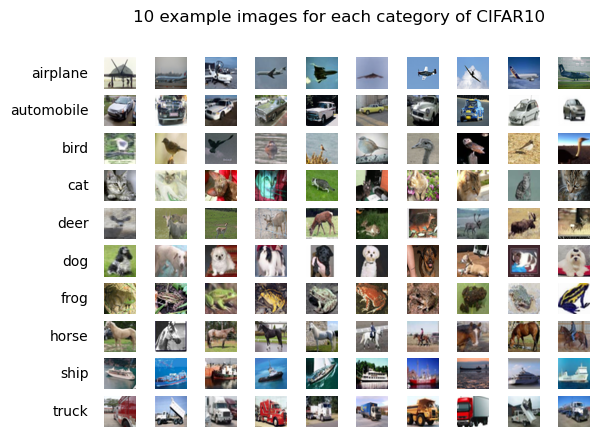

In [5]:
#(50000,32,32,3)
# Plot 10 images from each class

figure, axs = plt.subplots(10, 10)
# CIFAR10 dataset labels
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

for category in range(10):
	# Find all indices of current category in dataset
	indices = [i for i, x in enumerate(dataset_train.targets) if x == category]
	for image in range(10):
		random_img = random.choice(indices)
		axs[category][image].imshow(dataset_train.data[random_img])
		axs[category][image].axis('off')

	# Put the labels at the beginning of the rows
	axs[category][0].text(-0.5, 0.5, labels[category], va='center', ha='right', transform=axs[category][0].transAxes)
figure.suptitle("10 example images for each category of CIFAR10")
plt.show()




### 3.2 Network

In [5]:
class Net(nn.Module):
	def __init__(self):
		super().__init__()

		self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0)
		self.relu = nn.ReLU()
		self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
		self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)
		# After the convolutions and pooling, the dimension of the data should be (5, 5, 16) => 400
		self.fc1 = nn.Linear(in_features=400, out_features=120)
		self.fc2 = nn.Linear(in_features=120, out_features=84)
		self.fc3 = nn.Linear(in_features=84, out_features=10)
	
	def forward(self, x):
		# First convolution layer
		out = self.conv1(x)
		out = self.relu(out)
		out = self.maxpool(out)

		# Second convolution layer
		out = self.conv2(out)
		out = self.relu(out)
		out = self.maxpool(out)
		
		# First fully connected layer
		out = torch.flatten(out, start_dim=1) # don't flatten the batch
		out = self.fc1(out)
		out = self.relu(out)

		# Second fully connected layer
		out = self.fc2(out)
		out = self.relu(out)

		# Output fully connected layer
		out = self.fc3(out)
		
		############ end of your code############
		return out

In [7]:
model = Net()
# Print the trainable parameter count of the model. p.requires_grad denotes, that the parameter is trainable
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Trainable Parameters:", trainable_params)

Trainable Parameters: 62006


### 3.3 Training

In [ ]:
# Helper functions
def batch_accuracy(prediction, label):
	# Calculate the mean of all predicions compared with the true labels
	return (prediction == label).float().mean()

def class_label(prediction):
	return prediction.argmax(1) # return the classlabel of the highest value in each row

In [ ]:

def train(dataset_train, dataset_test, useCuda=False):
	# Hyperparameter
	epochs = 10
	lr = 0.001
	batch_size = 16

	# Add the datasets to the DataLoader
	dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
	dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

	# Instanziate model
	model = Net()
	optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
	criterion = nn.CrossEntropyLoss()

	if(useCuda):
		# Move model to cuda
		model.cuda()
		criterion.cuda()

	# Print the trainable parameter count of the model. p.requires_grad denotes, that the parameter is trainable
	trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
	print("Trainable parameters:", trainable_params)

	accuracies_train = []
	accuracies_test = []

	for epoch in tqdm(range(epochs), desc='Epoch'):
		# Train the model
		model.train()
		for step, sample in enumerate(dataloader_train):
			x, y = sample[0], sample[1]

			if(useCuda):
				x = x.cuda()
				y = y.cuda()
			
			# Clear existing gradients
			optimizer.zero_grad()

			# Forward pass
			y_pred = model(x)
			loss = criterion(y_pred, y)

			# Backward pass
			loss.backward()

			# Weight update
			optimizer.step()

			if (step % 375) == 0:
				tqdm.write('Batch Loss: {:.2f}'.format(loss))
		

		# Calculate Training Accuracies
		model.eval()
		accuracies_train_epoch = []
		with torch.no_grad():
			for sample in dataloader_train:
				x, y = sample[0], sample[1]

				if(useCuda):
					x = x.cuda()
					y = y.cuda()

				# Forward pass
				y_pred = model(x)

				acc = batch_accuracy(class_label(y_pred), y)
				accuracies_train_epoch.append(acc)
			accuracies_train_tensor = torch.tensor(accuracies_train_epoch).mean().item()
			accuracies_train.append(accuracies_train_tensor)

		# Test the model
		accuracies_test_epoch = []
		with torch.no_grad():
			for sample_test in dataloader_test:
				x_test, y_test = sample_test[0], sample_test[1]

				if(useCuda):
					x_test = x_test.cuda()
					y_test = y_test.cuda()

				# Forward pass
				y_test_pred = model(x_test)

				acc_test = batch_accuracy(class_label(y_test_pred), y_test)
				accuracies_test_epoch.append(acc_test)

			# Print test accuracy after each epoch
			accuracies_test_tensor = torch.tensor(accuracies_test_epoch).mean().item()
			print('Test Accuracy: {:.2f}%'.format(accuracies_test_tensor*100))
			accuracies_test.append(accuracies_test_tensor)

	# Transform to tensors
	accuracies_train = torch.Tensor(accuracies_train)
	accuracies_test = torch.Tensor(accuracies_test)

	# Save the model
	torch.save(model.state_dict(), 'perceptron_{}.ckpt'.format(step))

	return accuracies_train, accuracies_test



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

accuracies_train, accuracies_test = train(dataset_train=dataset_train, dataset_test=dataset_test, useCuda=True)

cuda
Trainable parameters: 62006


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]  


Batch Loss: 2.35


Epoch:   0%|          | 0/10 [00:01<?, ?it/s]             

Batch Loss: 2.05



Batch:  25%|██▌       | 792/3125 [00:03<00:10, 213.03it/s]

Batch Loss: 1.80



Epoch:   0%|          | 0/10 [00:05<?, ?it/s]              

Batch Loss: 1.64



Batch:  49%|████▉     | 1536/3125 [00:07<00:08, 196.88it/s]

Batch Loss: 1.53



Epoch:   0%|          | 0/10 [00:09<?, ?it/s]              

Batch Loss: 2.04



Epoch:   0%|          | 0/10 [00:11<?, ?it/s]              

Batch Loss: 1.20



Epoch:   0%|          | 0/10 [00:12<?, ?it/s]              

Batch Loss: 1.28



Epoch:   0%|          | 0/10 [00:14<?, ?it/s]              

Batch Loss: 1.07


Epoch:  10%|█         | 1/10 [00:27<04:04, 27.16s/it]

Test Accuracy: 44.96%



Epoch:  10%|█         | 1/10 [00:27<04:04, 27.16s/it]


Batch Loss: 1.61


Epoch:  10%|█         | 1/10 [00:28<04:04, 27.16s/it]     

Batch Loss: 1.64



Epoch:  10%|█         | 1/10 [00:30<04:04, 27.16s/it]     

Batch Loss: 1.20



Epoch:  10%|█         | 1/10 [00:32<04:04, 27.16s/it]      

Batch Loss: 1.69



Epoch:  10%|█         | 1/10 [00:34<04:04, 27.16s/it]      

Batch Loss: 1.34



Epoch:  10%|█         | 1/10 [00:35<04:04, 27.16s/it]      

Batch Loss: 1.32



Epoch:  10%|█         | 1/10 [00:37<04:04, 27.16s/it]      

Batch Loss: 1.55



Batch:  85%|████████▌ | 2671/3125 [00:12<00:02, 216.97it/s]

Batch Loss: 1.33



Epoch:  10%|█         | 1/10 [00:40<04:04, 27.16s/it]      

Batch Loss: 2.04


Epoch:  20%|██        | 2/10 [00:51<03:25, 25.68s/it]

Test Accuracy: 49.80%



Epoch:  20%|██        | 2/10 [00:51<03:25, 25.68s/it]

Batch Loss: 1.19



Batch:  13%|█▎        | 421/3125 [00:01<00:11, 228.43it/s]

Batch Loss: 1.77



Epoch:  20%|██        | 2/10 [00:55<03:25, 25.68s/it]     

Batch Loss: 1.47



Epoch:  20%|██        | 2/10 [00:56<03:25, 25.68s/it]      

Batch Loss: 1.29



Epoch:  20%|██        | 2/10 [00:58<03:25, 25.68s/it]      

Batch Loss: 2.15



Epoch:  20%|██        | 2/10 [01:00<03:25, 25.68s/it]      

Batch Loss: 1.09



Batch:  73%|███████▎  | 2295/3125 [00:10<00:03, 230.54it/s]

Batch Loss: 1.85



Epoch:  20%|██        | 2/10 [01:03<03:25, 25.68s/it]      

Batch Loss: 1.08



Epoch:  20%|██        | 2/10 [01:04<03:25, 25.68s/it]      

Batch Loss: 1.26


Epoch:  30%|███       | 3/10 [01:17<02:58, 25.47s/it]

Test Accuracy: 53.58%



Epoch:  30%|███       | 3/10 [01:17<02:58, 25.47s/it]


Batch Loss: 1.18


Epoch:  30%|███       | 3/10 [01:18<02:58, 25.47s/it]     

Batch Loss: 1.53



Epoch:  30%|███       | 3/10 [01:20<02:58, 25.47s/it]     


Batch Loss: 1.23


Epoch:  30%|███       | 3/10 [01:22<02:58, 25.47s/it]      

Batch Loss: 1.47



Epoch:  30%|███       | 3/10 [01:23<02:58, 25.47s/it]      

Batch Loss: 1.19



Epoch:  30%|███       | 3/10 [01:25<02:58, 25.47s/it]      

Batch Loss: 0.81



Epoch:  30%|███       | 3/10 [01:27<02:58, 25.47s/it]      

Batch Loss: 1.32



Batch:  85%|████████▌ | 2669/3125 [00:11<00:01, 229.06it/s]

Batch Loss: 1.24



Epoch:  30%|███       | 3/10 [01:30<02:58, 25.47s/it]      

Batch Loss: 1.30


Epoch:  40%|████      | 4/10 [01:41<02:29, 24.97s/it]

Test Accuracy: 54.74%



Epoch:  40%|████      | 4/10 [01:41<02:29, 24.97s/it]


Batch Loss: 1.37


Epoch:  40%|████      | 4/10 [01:42<02:29, 24.97s/it]     

Batch Loss: 1.01



Epoch:  40%|████      | 4/10 [01:44<02:29, 24.97s/it]     

Batch Loss: 1.06



Epoch:  40%|████      | 4/10 [01:46<02:29, 24.97s/it]      

Batch Loss: 1.24



Epoch:  40%|████      | 4/10 [01:47<02:29, 24.97s/it]      

Batch Loss: 1.20



Epoch:  40%|████      | 4/10 [01:49<02:29, 24.97s/it]      

Batch Loss: 1.47



Batch:  73%|███████▎  | 2291/3125 [00:10<00:03, 227.52it/s]

Batch Loss: 1.83



Batch:  86%|████████▌ | 2673/3125 [00:11<00:01, 231.09it/s]

Batch Loss: 1.12



Epoch:  40%|████      | 4/10 [01:54<02:29, 24.97s/it]      

Batch Loss: 0.80


Epoch:  50%|█████     | 5/10 [02:06<02:05, 25.02s/it]

Test Accuracy: 56.27%



Epoch:  50%|█████     | 5/10 [02:06<02:05, 25.02s/it]

Batch Loss: 0.80



Epoch:  50%|█████     | 5/10 [02:08<02:05, 25.02s/it]     

Batch Loss: 0.92



Batch:  25%|██▌       | 791/3125 [00:03<00:10, 229.28it/s]

Batch Loss: 0.93



Epoch:  50%|█████     | 5/10 [02:11<02:05, 25.02s/it]      

Batch Loss: 1.04



Epoch:  50%|█████     | 5/10 [02:13<02:05, 25.02s/it]      

Batch Loss: 1.08



Epoch:  50%|█████     | 5/10 [02:14<02:05, 25.02s/it]      

Batch Loss: 1.30



Epoch:  50%|█████     | 5/10 [02:16<02:05, 25.02s/it]      

Batch Loss: 1.03



Epoch:  50%|█████     | 5/10 [02:17<02:05, 25.02s/it]      

Batch Loss: 1.33



Epoch:  50%|█████     | 5/10 [02:19<02:05, 25.02s/it]      

Batch Loss: 1.17


Epoch:  60%|██████    | 6/10 [02:30<01:38, 24.69s/it]

Test Accuracy: 58.53%



Epoch:  60%|██████    | 6/10 [02:30<01:38, 24.69s/it]

Batch Loss: 0.87



Batch:  13%|█▎        | 418/3125 [00:01<00:11, 228.32it/s]

Batch Loss: 1.07



Batch:  26%|██▌       | 799/3125 [00:03<00:10, 230.50it/s]

Batch Loss: 0.61



Epoch:  60%|██████    | 6/10 [02:35<01:38, 24.69s/it]      

Batch Loss: 1.11



Epoch:  60%|██████    | 6/10 [02:36<01:38, 24.69s/it]      

Batch Loss: 1.12



Epoch:  60%|██████    | 6/10 [02:38<01:38, 24.69s/it]      

Batch Loss: 1.94



Batch:  74%|███████▎  | 2298/3125 [00:10<00:03, 225.89it/s]

Batch Loss: 1.16



Epoch:  60%|██████    | 6/10 [02:42<01:38, 24.69s/it]      

Batch Loss: 1.07



Epoch:  60%|██████    | 6/10 [02:43<01:38, 24.69s/it]      

Batch Loss: 1.35


Epoch:  70%|███████   | 7/10 [02:55<01:14, 24.83s/it]

Test Accuracy: 57.53%



Epoch:  70%|███████   | 7/10 [02:55<01:14, 24.83s/it]

Batch Loss: 1.01



Epoch:  70%|███████   | 7/10 [02:57<01:14, 24.83s/it]     

Batch Loss: 1.23



Epoch:  70%|███████   | 7/10 [02:58<01:14, 24.83s/it]     

Batch Loss: 0.98



Epoch:  70%|███████   | 7/10 [03:00<01:14, 24.83s/it]      

Batch Loss: 1.42



Epoch:  70%|███████   | 7/10 [03:02<01:14, 24.83s/it]      

Batch Loss: 1.10



Epoch:  70%|███████   | 7/10 [03:03<01:14, 24.83s/it]      

Batch Loss: 1.13



Epoch:  70%|███████   | 7/10 [03:05<01:14, 24.83s/it]      

Batch Loss: 0.82



Epoch:  70%|███████   | 7/10 [03:07<01:14, 24.83s/it]      

Batch Loss: 0.91



Epoch:  70%|███████   | 7/10 [03:08<01:14, 24.83s/it]      

Batch Loss: 0.66


Epoch:  80%|████████  | 8/10 [03:19<00:49, 24.64s/it]

Test Accuracy: 57.52%



Epoch:  80%|████████  | 8/10 [03:19<00:49, 24.64s/it]

Batch Loss: 1.10



Epoch:  80%|████████  | 8/10 [03:21<00:49, 24.64s/it]     

Batch Loss: 1.07



Epoch:  80%|████████  | 8/10 [03:23<00:49, 24.64s/it]     

Batch Loss: 1.02



Epoch:  80%|████████  | 8/10 [03:24<00:49, 24.64s/it]      

Batch Loss: 0.86



Epoch:  80%|████████  | 8/10 [03:26<00:49, 24.64s/it]      

Batch Loss: 1.23



Epoch:  80%|████████  | 8/10 [03:27<00:49, 24.64s/it]      

Batch Loss: 0.74



Batch:  74%|███████▎  | 2299/3125 [00:10<00:03, 231.81it/s]

Batch Loss: 1.15



Epoch:  80%|████████  | 8/10 [03:31<00:49, 24.64s/it]      

Batch Loss: 0.58



Epoch:  80%|████████  | 8/10 [03:32<00:49, 24.64s/it]      

Batch Loss: 1.41


Epoch:  90%|█████████ | 9/10 [03:44<00:24, 24.79s/it]

Test Accuracy: 59.63%



Epoch:  90%|█████████ | 9/10 [03:44<00:24, 24.79s/it]


Batch Loss: 0.69


Epoch:  90%|█████████ | 9/10 [03:46<00:24, 24.79s/it]     

Batch Loss: 1.05



Epoch:  90%|█████████ | 9/10 [03:48<00:24, 24.79s/it]     


Batch Loss: 1.47


Epoch:  90%|█████████ | 9/10 [03:49<00:24, 24.79s/it]      

Batch Loss: 0.89



Epoch:  90%|█████████ | 9/10 [03:51<00:24, 24.79s/it]      

Batch Loss: 0.82



Epoch:  90%|█████████ | 9/10 [03:53<00:24, 24.79s/it]      

Batch Loss: 1.36



Epoch:  90%|█████████ | 9/10 [03:54<00:24, 24.79s/it]      

Batch Loss: 0.86



Batch:  86%|████████▌ | 2674/3125 [00:11<00:01, 231.10it/s]

Batch Loss: 1.39



Epoch:  90%|█████████ | 9/10 [03:58<00:24, 24.79s/it]      

Batch Loss: 1.27


Epoch: 100%|██████████| 10/10 [04:08<00:00, 24.89s/it]

Test Accuracy: 58.51%


Plot how the accuracy (i.e. percentage of correctly classified images) of your model evolves for both, the training- and test-set of CIFAR10. Please make sure to add meaningful axis labels for your plot (y-axis as
the accuracy and x-axis as the epoch number).

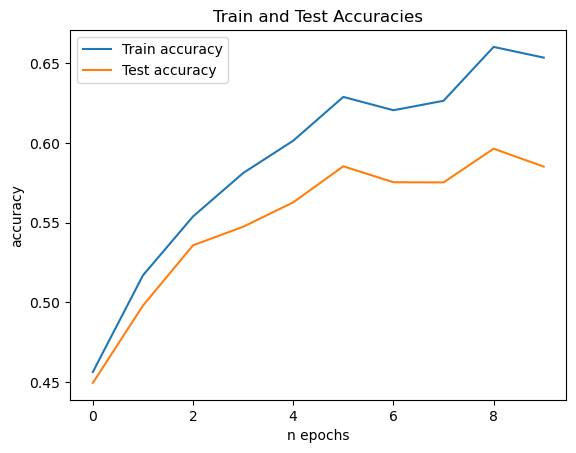

In [ ]:
plt.plot(accuracies_train, label="Train accuracy")
plt.plot(accuracies_test, label="Test accuracy")
plt.xlabel("n epochs")
plt.ylabel("accuracy")
plt.title("Train and Test Accuracies")
plt.legend()
plt.show()

What do you observe in the accuracy plot, in particular if you compare the train and test accuracy? Do you have an explanation for that?

The accuracy of both the train and test set increase, with the accuracy of the train set always being higher. This makes sense, since the model fits to the training data and thus it has a variance. With each epoch, the variance seems to increase further.

The accuracy curve is not very stable yet, so it might make sense to train the model for more epochs to find out if it will reach a stable peak.


### 3.4 Augmentation

Please apply random horizontal flipping, random cropping with padding=4, and ColorJitter to the CIFAR10 images and visualize a few pairs of augmented images against their original.

In [8]:
# The transformations that should be applied to the dataset
transforms = T.Compose([
	T.RandomHorizontalFlip(),
	T.RandomCrop(size=(32,32), padding=4),
	T.ColorJitter(),
	T.ToTensor(),
])

dataset_train_augmented = torchvision.datasets.CIFAR10('../data', train=True, download=True, transform=transforms)
dataset_test_augmented = torchvision.datasets.CIFAR10('../data', train=False, download=True, transform=transforms)

Files already downloaded and verified
Files already downloaded and verified


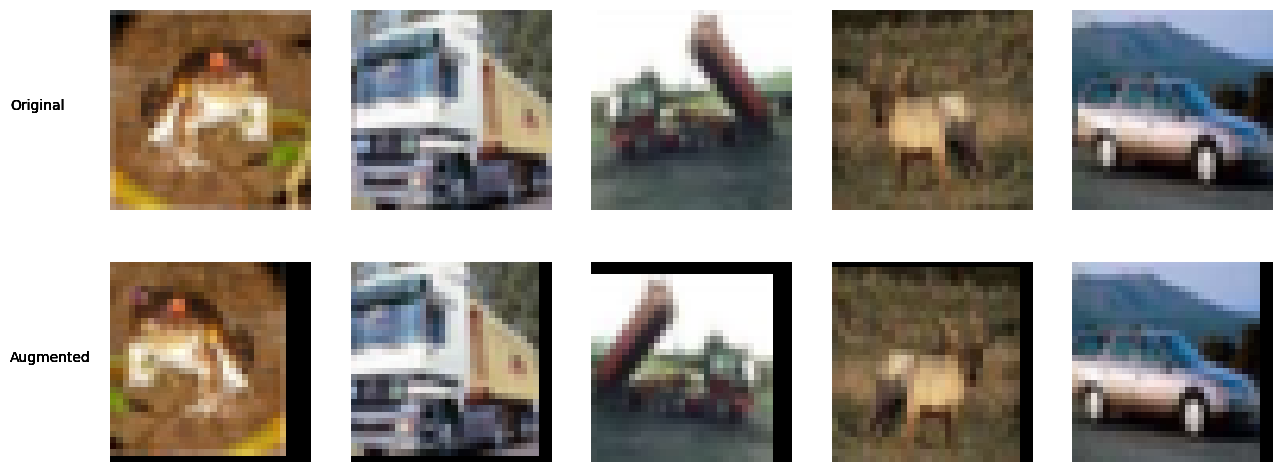

In [11]:
figure, axs = plt.subplots(2,5, figsize=(15, 6))


for i in range(5):
	image, label = dataset_train[i]
	image_aug, _ = dataset_train_augmented[i]

	# Change from (C,H,W) to (H,W,C)
	image = image.permute(1, 2, 0)
	image_aug = image_aug.permute(1, 2, 0)
		
	axs[0][i].imshow(image)
	axs[1][i].imshow(image_aug)
	axs[0][i].axis('off')
	axs[1][i].axis('off')
	axs[0][0].text(-0.5, 0.5, "Original", transform=axs[0][0].transAxes)
	axs[1][0].text(-0.5, 0.5, "Augmented", transform=axs[1][0].transAxes)

plt.show()

Train your model using the same setup as above, however, with additional normalization (normalize your input images channel-wise using μ = 0.5 and σ = 0.5) and data augmentation.

In [ ]:
# Normalize the datasets
normalize = T.Normalize(mean=0.5, std=0.5)

dataset_train_augmented = [(normalize(image), label) for image, label in dataset_train_augmented]
dataset_test_augmented = [(normalize(image), label) for image, label in dataset_test_augmented]


In [ ]:
accuracies_train_aug, accuracies_test_aug = train(dataset_train=dataset_train_augmented, dataset_test=dataset_test_augmented, useCuda=True)

Trainable parameters: 62006


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Batch Loss: 2.28


Epoch:   0%|          | 0/10 [00:03<?, ?it/s]

Batch Loss: 1.96


Epoch:   0%|          | 0/10 [00:06<?, ?it/s]

Batch Loss: 1.69


Epoch:   0%|          | 0/10 [00:10<?, ?it/s]

Batch Loss: 1.67


Epoch:   0%|          | 0/10 [00:13<?, ?it/s]

Batch Loss: 2.01


Epoch:   0%|          | 0/10 [00:16<?, ?it/s]

Batch Loss: 1.36


Epoch:   0%|          | 0/10 [00:19<?, ?it/s]

Batch Loss: 1.58


Epoch:   0%|          | 0/10 [00:22<?, ?it/s]

Batch Loss: 1.70


Epoch:   0%|          | 0/10 [00:26<?, ?it/s]

Batch Loss: 1.24


Epoch:  10%|█         | 1/10 [00:53<08:02, 53.61s/it]

Test Accuracy: 41.44%
Batch Loss: 1.50


Epoch:  10%|█         | 1/10 [00:56<08:02, 53.61s/it]

Batch Loss: 1.49


Epoch:  10%|█         | 1/10 [00:59<08:02, 53.61s/it]

Batch Loss: 1.74


Epoch:  10%|█         | 1/10 [01:03<08:02, 53.61s/it]

Batch Loss: 2.11


Epoch:  10%|█         | 1/10 [01:06<08:02, 53.61s/it]

Batch Loss: 1.29


Epoch:  10%|█         | 1/10 [01:09<08:02, 53.61s/it]

Batch Loss: 1.53


Epoch:  10%|█         | 1/10 [01:12<08:02, 53.61s/it]

Batch Loss: 1.85


Epoch:  10%|█         | 1/10 [01:15<08:02, 53.61s/it]

Batch Loss: 1.32


Epoch:  10%|█         | 1/10 [01:18<08:02, 53.61s/it]

Batch Loss: 1.39


Epoch:  20%|██        | 2/10 [01:45<06:59, 52.46s/it]

Test Accuracy: 45.19%
Batch Loss: 1.97


Epoch:  20%|██        | 2/10 [01:48<06:59, 52.46s/it]

Batch Loss: 1.71


Epoch:  20%|██        | 2/10 [01:51<06:59, 52.46s/it]

Batch Loss: 1.43


Epoch:  20%|██        | 2/10 [01:54<06:59, 52.46s/it]

Batch Loss: 1.24


Epoch:  20%|██        | 2/10 [01:57<06:59, 52.46s/it]

Batch Loss: 1.48


Epoch:  20%|██        | 2/10 [02:00<06:59, 52.46s/it]

Batch Loss: 1.31


Epoch:  20%|██        | 2/10 [02:03<06:59, 52.46s/it]

Batch Loss: 1.90


Epoch:  20%|██        | 2/10 [02:06<06:59, 52.46s/it]

Batch Loss: 1.58


Epoch:  20%|██        | 2/10 [02:09<06:59, 52.46s/it]

Batch Loss: 1.14


Epoch:  30%|███       | 3/10 [02:37<06:04, 52.13s/it]

Test Accuracy: 48.18%
Batch Loss: 1.39


Epoch:  30%|███       | 3/10 [02:39<06:04, 52.13s/it]

Batch Loss: 0.94


Epoch:  30%|███       | 3/10 [02:42<06:04, 52.13s/it]

Batch Loss: 1.24


Epoch:  30%|███       | 3/10 [02:45<06:04, 52.13s/it]

Batch Loss: 1.28


Epoch:  30%|███       | 3/10 [02:48<06:04, 52.13s/it]

Batch Loss: 1.27


Epoch:  30%|███       | 3/10 [02:51<06:04, 52.13s/it]

Batch Loss: 1.27


Epoch:  30%|███       | 3/10 [02:54<06:04, 52.13s/it]

Batch Loss: 1.52


Epoch:  30%|███       | 3/10 [02:57<06:04, 52.13s/it]

Batch Loss: 1.34


Epoch:  30%|███       | 3/10 [03:00<06:04, 52.13s/it]

Batch Loss: 1.65


Epoch:  40%|████      | 4/10 [03:26<05:05, 50.99s/it]

Test Accuracy: 51.21%
Batch Loss: 1.47


Epoch:  40%|████      | 4/10 [03:29<05:05, 50.99s/it]

Batch Loss: 1.46


Epoch:  40%|████      | 4/10 [03:32<05:05, 50.99s/it]

Batch Loss: 1.02


Epoch:  40%|████      | 4/10 [03:35<05:05, 50.99s/it]

Batch Loss: 1.49


Epoch:  40%|████      | 4/10 [03:38<05:05, 50.99s/it]

Batch Loss: 1.11


Epoch:  40%|████      | 4/10 [03:41<05:05, 50.99s/it]

Batch Loss: 1.86


Epoch:  40%|████      | 4/10 [03:44<05:05, 50.99s/it]

Batch Loss: 0.98


Epoch:  40%|████      | 4/10 [03:47<05:05, 50.99s/it]

Batch Loss: 1.47


Epoch:  40%|████      | 4/10 [03:49<05:05, 50.99s/it]

Batch Loss: 1.91


Epoch:  50%|█████     | 5/10 [04:15<04:12, 50.44s/it]

Test Accuracy: 52.46%
Batch Loss: 1.28


Epoch:  50%|█████     | 5/10 [04:18<04:12, 50.44s/it]

Batch Loss: 1.34


Epoch:  50%|█████     | 5/10 [04:21<04:12, 50.44s/it]

Batch Loss: 0.99


Epoch:  50%|█████     | 5/10 [04:24<04:12, 50.44s/it]

Batch Loss: 1.30


Epoch:  50%|█████     | 5/10 [04:27<04:12, 50.44s/it]

Batch Loss: 1.86


Epoch:  50%|█████     | 5/10 [04:30<04:12, 50.44s/it]

Batch Loss: 1.39


Epoch:  50%|█████     | 5/10 [04:33<04:12, 50.44s/it]

Batch Loss: 1.16


Epoch:  50%|█████     | 5/10 [04:36<04:12, 50.44s/it]

Batch Loss: 1.29


Epoch:  50%|█████     | 5/10 [04:39<04:12, 50.44s/it]

Batch Loss: 0.97


Epoch:  60%|██████    | 6/10 [05:04<03:19, 49.81s/it]

Test Accuracy: 52.81%
Batch Loss: 1.70


Epoch:  60%|██████    | 6/10 [05:07<03:19, 49.81s/it]

Batch Loss: 1.02


Epoch:  60%|██████    | 6/10 [05:10<03:19, 49.81s/it]

Batch Loss: 1.32


Epoch:  60%|██████    | 6/10 [05:13<03:19, 49.81s/it]

Batch Loss: 1.89


Epoch:  60%|██████    | 6/10 [05:16<03:19, 49.81s/it]

Batch Loss: 1.67


Epoch:  60%|██████    | 6/10 [05:19<03:19, 49.81s/it]

Batch Loss: 0.95


Epoch:  60%|██████    | 6/10 [05:22<03:19, 49.81s/it]

Batch Loss: 1.10


Epoch:  60%|██████    | 6/10 [05:25<03:19, 49.81s/it]

Batch Loss: 0.93


Epoch:  60%|██████    | 6/10 [05:28<03:19, 49.81s/it]

Batch Loss: 1.09


Epoch:  70%|███████   | 7/10 [05:54<02:29, 49.82s/it]

Test Accuracy: 54.94%
Batch Loss: 1.66


Epoch:  70%|███████   | 7/10 [05:57<02:29, 49.82s/it]

Batch Loss: 1.01


Epoch:  70%|███████   | 7/10 [06:00<02:29, 49.82s/it]

Batch Loss: 1.09


Epoch:  70%|███████   | 7/10 [06:03<02:29, 49.82s/it]

Batch Loss: 1.36


Epoch:  70%|███████   | 7/10 [06:06<02:29, 49.82s/it]

Batch Loss: 1.27


Epoch:  70%|███████   | 7/10 [06:09<02:29, 49.82s/it]

Batch Loss: 1.21


Epoch:  70%|███████   | 7/10 [06:12<02:29, 49.82s/it]

Batch Loss: 1.03


Epoch:  70%|███████   | 7/10 [06:15<02:29, 49.82s/it]

Batch Loss: 1.01


Epoch:  70%|███████   | 7/10 [06:18<02:29, 49.82s/it]

Batch Loss: 1.21


Epoch:  80%|████████  | 8/10 [06:43<01:39, 49.78s/it]

Test Accuracy: 54.71%
Batch Loss: 0.97


Epoch:  80%|████████  | 8/10 [06:46<01:39, 49.78s/it]

Batch Loss: 1.00


Epoch:  80%|████████  | 8/10 [06:50<01:39, 49.78s/it]

Batch Loss: 1.50


Epoch:  80%|████████  | 8/10 [06:52<01:39, 49.78s/it]

Batch Loss: 1.55


Epoch:  80%|████████  | 8/10 [06:56<01:39, 49.78s/it]

Batch Loss: 1.08


Epoch:  80%|████████  | 8/10 [06:58<01:39, 49.78s/it]

Batch Loss: 1.02


Epoch:  80%|████████  | 8/10 [07:01<01:39, 49.78s/it]

Batch Loss: 1.03


Epoch:  80%|████████  | 8/10 [07:04<01:39, 49.78s/it]

Batch Loss: 1.41


Epoch:  80%|████████  | 8/10 [07:07<01:39, 49.78s/it]

Batch Loss: 1.56


Epoch:  90%|█████████ | 9/10 [07:33<00:49, 49.79s/it]

Test Accuracy: 54.41%
Batch Loss: 0.94


Epoch:  90%|█████████ | 9/10 [07:37<00:49, 49.79s/it]

Batch Loss: 0.89


Epoch:  90%|█████████ | 9/10 [07:40<00:49, 49.79s/it]

Batch Loss: 1.34


Epoch:  90%|█████████ | 9/10 [07:43<00:49, 49.79s/it]

Batch Loss: 1.14


Epoch:  90%|█████████ | 9/10 [07:46<00:49, 49.79s/it]

Batch Loss: 1.11


Epoch:  90%|█████████ | 9/10 [07:49<00:49, 49.79s/it]

Batch Loss: 1.40


Epoch:  90%|█████████ | 9/10 [07:52<00:49, 49.79s/it]

Batch Loss: 1.06


Epoch:  90%|█████████ | 9/10 [07:56<00:49, 49.79s/it]

Batch Loss: 1.94


Epoch:  90%|█████████ | 9/10 [07:59<00:49, 49.79s/it]

Batch Loss: 1.15


Epoch: 100%|██████████| 10/10 [08:25<00:00, 50.52s/it]

Test Accuracy: 54.73%


Plot the accuracy of this model and the one you trained before over time. Make sure to use proper axis labels and a meaningful legend.

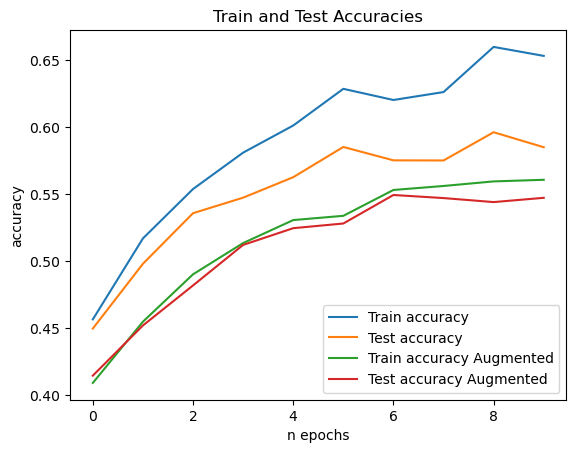

In [ ]:
plt.plot(accuracies_train, label="Train accuracy")
plt.plot(accuracies_test, label="Test accuracy")
plt.plot(accuracies_train_aug, label="Train accuracy Augmented")
plt.plot(accuracies_test_aug, label="Test accuracy Augmented")
plt.xlabel("n epochs")
plt.ylabel("accuracy")
plt.title("Train and Test Accuracies")
plt.legend()
plt.show()

Based on your results, provide a brief discussion of why the extra normalization and augmentation improves/harms the performance of your model.

It makes sense, that the extra normalization and augmentation harms the performance of the model, because only the augmented data is provided and not in addition to the original data. The augmentation makes the dataset less clear and thus harder to learn for the model.

#### Test, if the accuracy will improve if the augmented dataset is combined with the original dataset

In [ ]:
# Get the lengths of the datasets
train_length = len(dataset_train)
test_length = len(dataset_test)

# Create subsets of the datasets
first_half_train = Subset(dataset_train, indices=range(0, train_length // 2))
second_half_train_augmented = Subset(dataset_train_augmented, indices=range(train_length // 2, train_length))

first_half_test = Subset(dataset_test, indices=range(0, test_length // 2))
second_half_test_augmented = Subset(dataset_test_augmented, indices=range(test_length // 2, test_length))

# Combine the datasets
dataset_train_combined = ConcatDataset([first_half_train, second_half_train_augmented])
dataset_test_combined = ConcatDataset([first_half_test, second_half_test_augmented])

In [ ]:
accuracies_train_comb, accuracies_test_comb = train(dataset_train=dataset_train_combined, dataset_test=dataset_test_combined, useCuda=True)

Trainable parameters: 62006


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Batch Loss: 2.30


Epoch:   0%|          | 0/10 [00:02<?, ?it/s]

Batch Loss: 1.92


Epoch:   0%|          | 0/10 [00:05<?, ?it/s]

Batch Loss: 1.90


Epoch:   0%|          | 0/10 [00:07<?, ?it/s]

Batch Loss: 1.62


Epoch:   0%|          | 0/10 [00:09<?, ?it/s]

Batch Loss: 1.61


Epoch:   0%|          | 0/10 [00:12<?, ?it/s]

Batch Loss: 1.88


Epoch:   0%|          | 0/10 [00:14<?, ?it/s]

Batch Loss: 1.56


Epoch:   0%|          | 0/10 [00:17<?, ?it/s]

Batch Loss: 1.58


Epoch:   0%|          | 0/10 [00:19<?, ?it/s]

Batch Loss: 1.70


Epoch:  10%|█         | 1/10 [00:39<05:57, 39.69s/it]

Test Accuracy: 43.35%
Batch Loss: 1.65


Epoch:  10%|█         | 1/10 [00:42<05:57, 39.69s/it]

Batch Loss: 1.30


Epoch:  10%|█         | 1/10 [00:44<05:57, 39.69s/it]

Batch Loss: 1.67


Epoch:  10%|█         | 1/10 [00:47<05:57, 39.69s/it]

Batch Loss: 1.29


Epoch:  10%|█         | 1/10 [00:49<05:57, 39.69s/it]

Batch Loss: 1.37


Epoch:  10%|█         | 1/10 [00:51<05:57, 39.69s/it]

Batch Loss: 2.07


Epoch:  10%|█         | 1/10 [00:54<05:57, 39.69s/it]

Batch Loss: 1.84


Epoch:  10%|█         | 1/10 [00:56<05:57, 39.69s/it]

Batch Loss: 1.56


Epoch:  10%|█         | 1/10 [00:59<05:57, 39.69s/it]

Batch Loss: 1.21


Epoch:  20%|██        | 2/10 [01:19<05:17, 39.70s/it]

Test Accuracy: 48.63%
Batch Loss: 1.55


Epoch:  20%|██        | 2/10 [01:21<05:17, 39.70s/it]

Batch Loss: 1.21


Epoch:  20%|██        | 2/10 [01:24<05:17, 39.70s/it]

Batch Loss: 1.66


Epoch:  20%|██        | 2/10 [01:26<05:17, 39.70s/it]

Batch Loss: 1.84


Epoch:  20%|██        | 2/10 [01:29<05:17, 39.70s/it]

Batch Loss: 1.12


Epoch:  20%|██        | 2/10 [01:31<05:17, 39.70s/it]

Batch Loss: 1.78


Epoch:  20%|██        | 2/10 [01:34<05:17, 39.70s/it]

Batch Loss: 1.24


Epoch:  20%|██        | 2/10 [01:36<05:17, 39.70s/it]

Batch Loss: 1.39


Epoch:  20%|██        | 2/10 [01:39<05:17, 39.70s/it]

Batch Loss: 1.52


Epoch:  30%|███       | 3/10 [01:59<04:38, 39.74s/it]

Test Accuracy: 50.56%
Batch Loss: 1.35


Epoch:  30%|███       | 3/10 [02:01<04:38, 39.74s/it]

Batch Loss: 1.66


Epoch:  30%|███       | 3/10 [02:04<04:38, 39.74s/it]

Batch Loss: 0.99


Epoch:  30%|███       | 3/10 [02:06<04:38, 39.74s/it]

Batch Loss: 1.28


Epoch:  30%|███       | 3/10 [02:09<04:38, 39.74s/it]

Batch Loss: 1.82


Epoch:  30%|███       | 3/10 [02:11<04:38, 39.74s/it]

Batch Loss: 1.38


Epoch:  30%|███       | 3/10 [02:14<04:38, 39.74s/it]

Batch Loss: 1.59


Epoch:  30%|███       | 3/10 [02:16<04:38, 39.74s/it]

Batch Loss: 0.93


Epoch:  30%|███       | 3/10 [02:19<04:38, 39.74s/it]

Batch Loss: 1.06


Epoch:  40%|████      | 4/10 [02:40<04:00, 40.16s/it]

Test Accuracy: 52.56%
Batch Loss: 0.82


Epoch:  40%|████      | 4/10 [02:42<04:00, 40.16s/it]

Batch Loss: 1.10


Epoch:  40%|████      | 4/10 [02:44<04:00, 40.16s/it]

Batch Loss: 1.17


Epoch:  40%|████      | 4/10 [02:47<04:00, 40.16s/it]

Batch Loss: 1.90


Epoch:  40%|████      | 4/10 [02:49<04:00, 40.16s/it]

Batch Loss: 1.36


Epoch:  40%|████      | 4/10 [02:51<04:00, 40.16s/it]

Batch Loss: 1.11


Epoch:  40%|████      | 4/10 [02:54<04:00, 40.16s/it]

Batch Loss: 0.89


Epoch:  40%|████      | 4/10 [02:56<04:00, 40.16s/it]

Batch Loss: 1.52


Epoch:  40%|████      | 4/10 [02:58<04:00, 40.16s/it]

Batch Loss: 1.23


Epoch:  50%|█████     | 5/10 [03:17<03:16, 39.30s/it]

Test Accuracy: 54.29%
Batch Loss: 0.85


Epoch:  50%|█████     | 5/10 [03:20<03:16, 39.30s/it]

Batch Loss: 1.30


Epoch:  50%|█████     | 5/10 [03:22<03:16, 39.30s/it]

Batch Loss: 0.94


Epoch:  50%|█████     | 5/10 [03:25<03:16, 39.30s/it]

Batch Loss: 1.20


Epoch:  50%|█████     | 5/10 [03:27<03:16, 39.30s/it]

Batch Loss: 1.26


Epoch:  50%|█████     | 5/10 [03:30<03:16, 39.30s/it]

Batch Loss: 1.21


Epoch:  50%|█████     | 5/10 [03:32<03:16, 39.30s/it]

Batch Loss: 1.34


Epoch:  50%|█████     | 5/10 [03:35<03:16, 39.30s/it]

Batch Loss: 1.51


Epoch:  50%|█████     | 5/10 [03:37<03:16, 39.30s/it]

Batch Loss: 1.04


Epoch:  60%|██████    | 6/10 [03:58<02:39, 39.79s/it]

Test Accuracy: 54.04%
Batch Loss: 1.08


Epoch:  60%|██████    | 6/10 [04:01<02:39, 39.79s/it]

Batch Loss: 1.05


Epoch:  60%|██████    | 6/10 [04:04<02:39, 39.79s/it]

Batch Loss: 1.43


Epoch:  60%|██████    | 6/10 [04:06<02:39, 39.79s/it]

Batch Loss: 0.95


Epoch:  60%|██████    | 6/10 [04:08<02:39, 39.79s/it]

Batch Loss: 1.06


Epoch:  60%|██████    | 6/10 [04:11<02:39, 39.79s/it]

Batch Loss: 1.27


Epoch:  60%|██████    | 6/10 [04:13<02:39, 39.79s/it]

Batch Loss: 1.12


Epoch:  60%|██████    | 6/10 [04:16<02:39, 39.79s/it]

Batch Loss: 1.08


Epoch:  60%|██████    | 6/10 [04:18<02:39, 39.79s/it]

Batch Loss: 1.62


Epoch:  70%|███████   | 7/10 [04:38<01:59, 39.85s/it]

Test Accuracy: 56.98%
Batch Loss: 1.16


Epoch:  70%|███████   | 7/10 [04:40<01:59, 39.85s/it]

Batch Loss: 1.43


Epoch:  70%|███████   | 7/10 [04:43<01:59, 39.85s/it]

Batch Loss: 1.03


Epoch:  70%|███████   | 7/10 [04:45<01:59, 39.85s/it]

Batch Loss: 1.54


Epoch:  70%|███████   | 7/10 [04:48<01:59, 39.85s/it]

Batch Loss: 1.14


Epoch:  70%|███████   | 7/10 [04:50<01:59, 39.85s/it]

Batch Loss: 1.11


Epoch:  70%|███████   | 7/10 [04:53<01:59, 39.85s/it]

Batch Loss: 1.35


Epoch:  70%|███████   | 7/10 [04:55<01:59, 39.85s/it]

Batch Loss: 1.33


Epoch:  70%|███████   | 7/10 [04:58<01:59, 39.85s/it]

Batch Loss: 1.20


Epoch:  80%|████████  | 8/10 [05:19<01:20, 40.08s/it]

Test Accuracy: 56.43%
Batch Loss: 0.87


Epoch:  80%|████████  | 8/10 [05:21<01:20, 40.08s/it]

Batch Loss: 1.67


Epoch:  80%|████████  | 8/10 [05:23<01:20, 40.08s/it]

Batch Loss: 1.53


Epoch:  80%|████████  | 8/10 [05:26<01:20, 40.08s/it]

Batch Loss: 1.45


Epoch:  80%|████████  | 8/10 [05:28<01:20, 40.08s/it]

Batch Loss: 0.85


Epoch:  80%|████████  | 8/10 [05:30<01:20, 40.08s/it]

Batch Loss: 0.75


Epoch:  80%|████████  | 8/10 [05:33<01:20, 40.08s/it]

Batch Loss: 1.19


Epoch:  80%|████████  | 8/10 [05:35<01:20, 40.08s/it]

Batch Loss: 1.26


Epoch:  80%|████████  | 8/10 [05:37<01:20, 40.08s/it]

Batch Loss: 1.05


Epoch:  90%|█████████ | 9/10 [05:56<00:39, 39.26s/it]

Test Accuracy: 57.88%
Batch Loss: 1.64


Epoch:  90%|█████████ | 9/10 [05:58<00:39, 39.26s/it]

Batch Loss: 1.26


Epoch:  90%|█████████ | 9/10 [06:01<00:39, 39.26s/it]

Batch Loss: 1.18


Epoch:  90%|█████████ | 9/10 [06:03<00:39, 39.26s/it]

Batch Loss: 1.29


Epoch:  90%|█████████ | 9/10 [06:05<00:39, 39.26s/it]

Batch Loss: 0.84


Epoch:  90%|█████████ | 9/10 [06:08<00:39, 39.26s/it]

Batch Loss: 1.28


Epoch:  90%|█████████ | 9/10 [06:10<00:39, 39.26s/it]

Batch Loss: 1.03


Epoch:  90%|█████████ | 9/10 [06:13<00:39, 39.26s/it]

Batch Loss: 1.37


Epoch:  90%|█████████ | 9/10 [06:15<00:39, 39.26s/it]

Batch Loss: 0.84


Epoch: 100%|██████████| 10/10 [06:36<00:00, 39.60s/it]

Test Accuracy: 57.98%


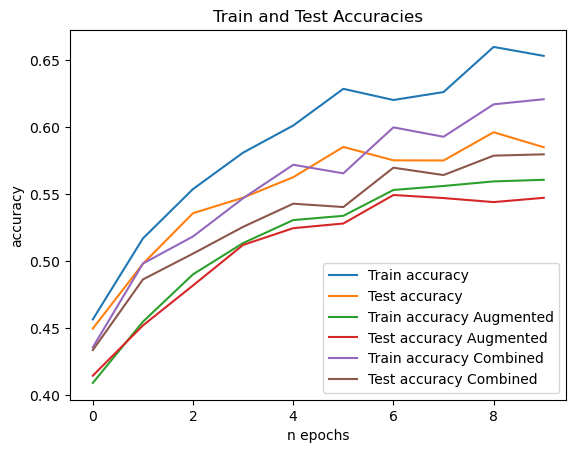

In [ ]:
plt.plot(accuracies_train, label="Train accuracy")
plt.plot(accuracies_test, label="Test accuracy")
plt.plot(accuracies_train_aug, label="Train accuracy Augmented")
plt.plot(accuracies_test_aug, label="Test accuracy Augmented")
plt.plot(accuracies_train_comb, label="Train accuracy Combined")
plt.plot(accuracies_test_comb, label="Test accuracy Combined")
plt.xlabel("n epochs")
plt.ylabel("accuracy")
plt.title("Train and Test Accuracies")
plt.legend()
plt.show()

A combination of both of the original dataset as well as the augmented dataset still does not perform as well as only taking the original dataset. By using the full original and augmented datasets combined, a bet accuracy can probably be achieved

---
## Task 4: Activation and Saliency Maps

In this task, we will try to visualize what CNNs learn by means of the activation
map, which is considered to be more informative than just visualizing e.g. the
kernel weights.

### 4.1 Instantiate a pre-traind ResNet18

In [14]:

############ your code here ############
# Instantiate your model ResNet18
# turn the model into evaluation mode
# and print out the architecture 

model = resnet18(weights=ResNet18_Weights.DEFAULT) # Instantiate pretrained model
batch_size = 16
summary(model, input_size=(batch_size,3, 224, 224))

############ end of your code############

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [16, 1000]                --
├─Conv2d: 1-1                            [16, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [16, 64, 112, 112]        128
├─ReLU: 1-3                              [16, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [16, 64, 56, 56]          --
├─Sequential: 1-5                        [16, 64, 56, 56]          --
│    └─BasicBlock: 2-1                   [16, 64, 56, 56]          --
│    │    └─Conv2d: 3-1                  [16, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-2             [16, 64, 56, 56]          128
│    │    └─ReLU: 3-3                    [16, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [16, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-5             [16, 64, 56, 56]          128
│    │    └─ReLU: 3-6                    [16, 64, 56, 56]          --
│

### 4.2 Intermediate Activation Maps

torch.Size([3, 224, 224])


c:\Users\adria\anaconda3\envs\genai\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


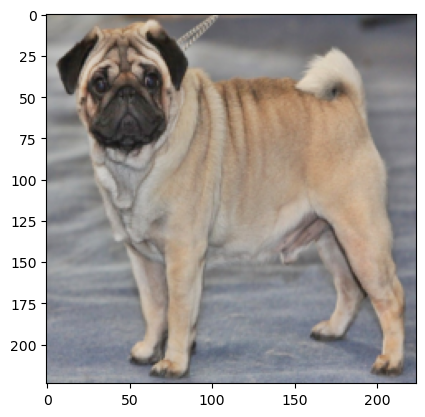

In [15]:
# check for gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load the provided image and get the output
image = Image.open('pug.jpg')
transform = T.Compose([T.Resize((224, 224)), T.ToTensor()])
X = transform(image).unsqueeze(dim=0).to(device)

def show_tensor(tensor):
	if tensor.ndim == 4:
		temp = tensor.squeeze()
	else: temp=tensor
	print(temp.shape)
	plt.imshow(temp.cpu().permute(1,2,0))

show_tensor(X)

model.to(device)
output =  model(X)

Store intermediate activation maps..


In [16]:
############ your code here ############

# This function returns the list of all the specific names of the nodes/layers in the Neural Network
train_nodes, _ = get_graph_node_names(model)
layer1 = train_nodes[5] # layer1.0.conv1
layer2 = train_nodes[31] # layer2.1.conv2
activation_maps = {
	layer1: 'activation1',
	layer2: 'activation2'
}
# Instantiate a new model which allows activation extraction of specified activations
extraction_model = create_feature_extractor(model=model, return_nodes=activation_maps)

out = extraction_model(X)
activation1 = out['activation1'].cpu().detach()
activation2 = out['activation2'].cpu().detach()
print("layer1.0.conv1:", activation1.shape)
print("layer2.1.conv2:", activation2.shape)
############ end of your code############

layer1.0.conv1: torch.Size([1, 64, 56, 56])
layer2.1.conv2: torch.Size([1, 128, 28, 28])


### 4.3 Visualize the Activation Maps

torch.Size([1, 64, 56, 56])
torch.Size([3136, 64])
torch.Size([1, 128, 28, 28])
torch.Size([784, 128])


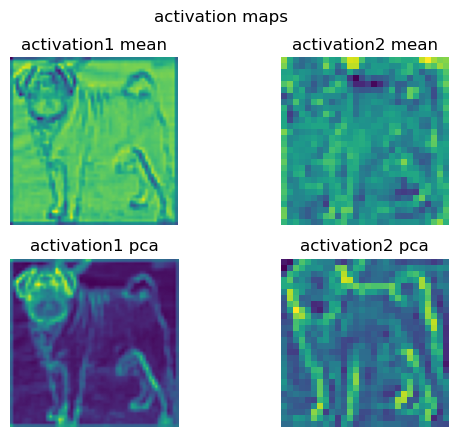

In [17]:
############ your code here ############
# reduce your activation maps' channel to a 'plottable' number
# you can use pca or any dimensionality reduction methods

#######################################
########### activation 1 ##############
#######################################

# Take the mean of the first 10 channels
activation1_10c = activation1[:,0:10]
activation1_mean = torch.mean(activation1_10c, dim=1).squeeze()

# Perform pca
pca = PCA(n_components=1)

print(activation1.shape)
n, c, h, w = activation1.shape
activation1_reshaped = activation1.permute(0,2,3,1).view(-1, c)
print(activation1_reshaped.shape)
activation1_pca = pca.fit_transform(activation1_reshaped)
activation1_pca = activation1_pca.reshape(h, w)

#######################################
########### activation 2 ##############
#######################################

# Take the mean of the first 10 channels
activation2_10c = activation2[:,0:10]
activation2_mean = torch.mean(activation2_10c, dim=1).squeeze()
# The layer is quite forward and the thus the resolution is lower. 
# The dog cannot be seen anymore, but the top left corner of the image is still the most important part.

# Perform pca
print(activation2.shape)
n, c, h, w = activation2.shape
activation2_reshaped = activation2.permute(0,2,3,1).view(-1, c)
print(activation2_reshaped.shape)
activation2_pca = pca.fit_transform(activation2_reshaped)
activation2_pca = activation2_pca.reshape(h, w)


# Visualize both dimensionality reduction methods on both activations
figure, axs = plt.subplots(2,2)
figure.suptitle("activation maps")
axs[0, 0].imshow(activation1_mean)
axs[0, 0].set_title("activation1 mean")
axs[0, 0].axis("off")

axs[1, 0].imshow(activation1_pca)
axs[1, 0].set_title("activation1 pca")
axs[1, 0].axis("off")
axs[0, 1].imshow(activation2_mean)
axs[0, 1].set_title("activation2 mean")
axs[0, 1].axis("off")
axs[1, 1].imshow(activation2_pca)
axs[1, 1].set_title("activation2 pca")
axs[1, 1].axis("off")

plt.show()

From the comparison above it is obvious, that the pca works way better than taking the mean for both activation1 and activation2

For activation1 the pca method deems the head as the most important feature as well as the shape of the legs

For activation2 the pca method deems the overall shape of the dog seems to be more important

### 4.4 Plot Image and Activation Map

(-0.5, 223.5, 223.5, -0.5)

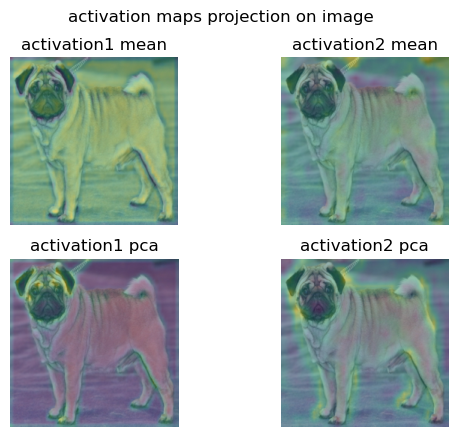

In [18]:
############ your code here ############
# visualize one of the activation maps on top of the original image
# you may need image resampling for this and the imshow(...,alpha=)
# value to overlap images with transparency.


upscale = T.Compose([T.Resize((224,224))])
X_image = X.cpu().squeeze().permute(1,2,0)

#######################################
########### activation 1 ##############
#######################################

# Mean 
activation1_mean_up = upscale(activation1_mean.unsqueeze(dim=0))
activation1_mean_up = activation1_mean_up.permute(1, 2, 0)

# PCA
activation1_pca_up = upscale(torch.tensor(activation1_pca).unsqueeze(dim=0))
activation1_pca_up = activation1_pca_up.permute(1, 2, 0)

#######################################
########### activation 2 ##############
#######################################

# Mean 
activation2_mean_up = upscale(activation2_mean.unsqueeze(dim=0))
activation2_mean_up = activation2_mean_up.permute(1, 2, 0)

# PCA
activation2_pca_up = upscale(torch.tensor(activation2_pca).unsqueeze(dim=0))
activation2_pca_up = activation2_pca_up.permute(1, 2, 0)


# Visualize both dimensionality reduction methods on both activations onto the original image
figure, axs = plt.subplots(2,2)
figure.suptitle("activation maps projection on image")
axs[0, 0].imshow(X_image)
axs[0, 0].imshow(activation1_mean_up, alpha=0.4)
axs[0, 0].set_title("activation1 mean")
axs[0, 0].axis("off")
axs[1, 0].imshow(X_image)
axs[1, 0].imshow(activation1_pca_up, alpha=0.4)
axs[1, 0].set_title("activation1 pca")
axs[1, 0].axis("off")
axs[0, 1].imshow(X_image)
axs[0, 1].imshow(activation2_mean_up, alpha=0.4)
axs[0, 1].set_title("activation2 mean")
axs[0, 1].axis("off")
axs[1, 1].imshow(X_image)
axs[1, 1].imshow(activation2_pca_up, alpha=0.4)
axs[1, 1].set_title("activation2 pca")
axs[1, 1].axis("off")
############ end of your code############

**activation1 mean:** seems to look at the whole image appart from the face which doesn't make sense to me

**activation1 pca:** It looks mostly at the face, which makes sense, since the face is usually very distinct from other species. It completely disregards most of the animal shape though, which I wouldn't do.

**activation2 mean:** It looks mostly at the top of the image which doesn't make sense.

**activation2 pca:** It takes a bit less focus on the face, than activation1 pca, but instead way more focus on the shape of the dog. 

In conclusion, both pca's of activation1 and activation2 make sense and the mean activations do not really make any sense.


### 4.5 Saliency Map
Introduced in: *Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps*

In [19]:
# illustrate how gather() works
def gather_example():
	N, C = 4, 5
	s = torch.randn(N, C)
	y = torch.LongTensor([1, 2, 1, 3])
	print(s)
	print(y)
	print(s.gather(1, y.view(-1, 1)).squeeze())
gather_example()

# load the images
names = ['catdog_243.png', 'catdog_243.png', 'snake_56.png', 'spider_72.png']

X = [np.array(Image.open(name).convert('RGB')) for name in names]
y = [int(s.rsplit('_')[1].rsplit('.')[0]) for s in names]

# intentionally change the label to a wrong one
y[1] = 285

def preprocess(img, size=224):
	transform = T.Compose([
		T.Resize(size),
		T.ToTensor(),
		T.Lambda(lambda x: x[None]),  # equivalent to unsqueeze()
	])
	return transform(img)

tensor([[-1.9425, -0.7353,  0.0636,  1.5861, -0.0030],
        [ 0.3235, -0.1199,  1.1265,  0.5234, -1.2329],
        [ 0.8290, -2.6207, -0.9826, -1.1423,  0.9420],
        [-0.2428,  2.4518,  0.3017, -0.5126,  0.4844]])
tensor([1, 2, 1, 3])
tensor([-0.7353,  1.1265, -2.6207, -0.5126])


#### a) Complete the saliency map function.

In [33]:
def saliency_maps(X, y, model, device):
	"""
	Compute a class saliency map using the model for images X and labels y.

	Input:
	- X: Input images; Tensor of shape (N, 3, H, W)
	- y: Labels for X; LongTensor of shape (N,)
	- model: A pretrained CNN that will be used to compute the saliency map.
	- device: Device on which the model is executed (cpu or gpu)

	Returns:
	- saliency: A Tensor of shape (N, H, W) giving the saliency maps for the input
	images.
	"""
	# Make sure the model is in "test" mode
	model.eval()
	
	# Wrap the input tensors in Variables
	X_var = X.clone().detach().to(device)
	X_var.requires_grad = True
	y_var = y.clone().detach().to(device)
	saliency = None

	##############################################################################
	# TODO: Implement this function. Perform a forward and backward pass through #
	# the model to compute the gradient of the correct class score with respect  #
	# to each input image. You first want to compute the loss over the correct   #
	# scores, and then compute the gradients with a backward pass.               #
	##############################################################################
	criterion = nn.CrossEntropyLoss()

	model.to(device)
	criterion.to(device)

	# Forward pass
	y_pred = model(X_var)
	loss = criterion(y_pred, y_var) 
	model.zero_grad()
	loss.backward()
	
	# calculate the saliency by taking the absolut value of each pixel, then taking the highest value from the RGB channels
	saliency = X_var.grad.abs().max(dim=1)[0]
   

	##############################################################################
	#                             END OF YOUR CODE                               #
	##############################################################################
	return saliency.cpu()

#### b) Visualize the original images together with the saliency maps.

Visualize the original image with the saliency maps together and provide a short discussion on why different ground truth labels with even the same input image would yield different saliency maps, for instance, the catdog_243.png image with y = 243 (bull mastiff) and y = 285 (Egyptian cat).

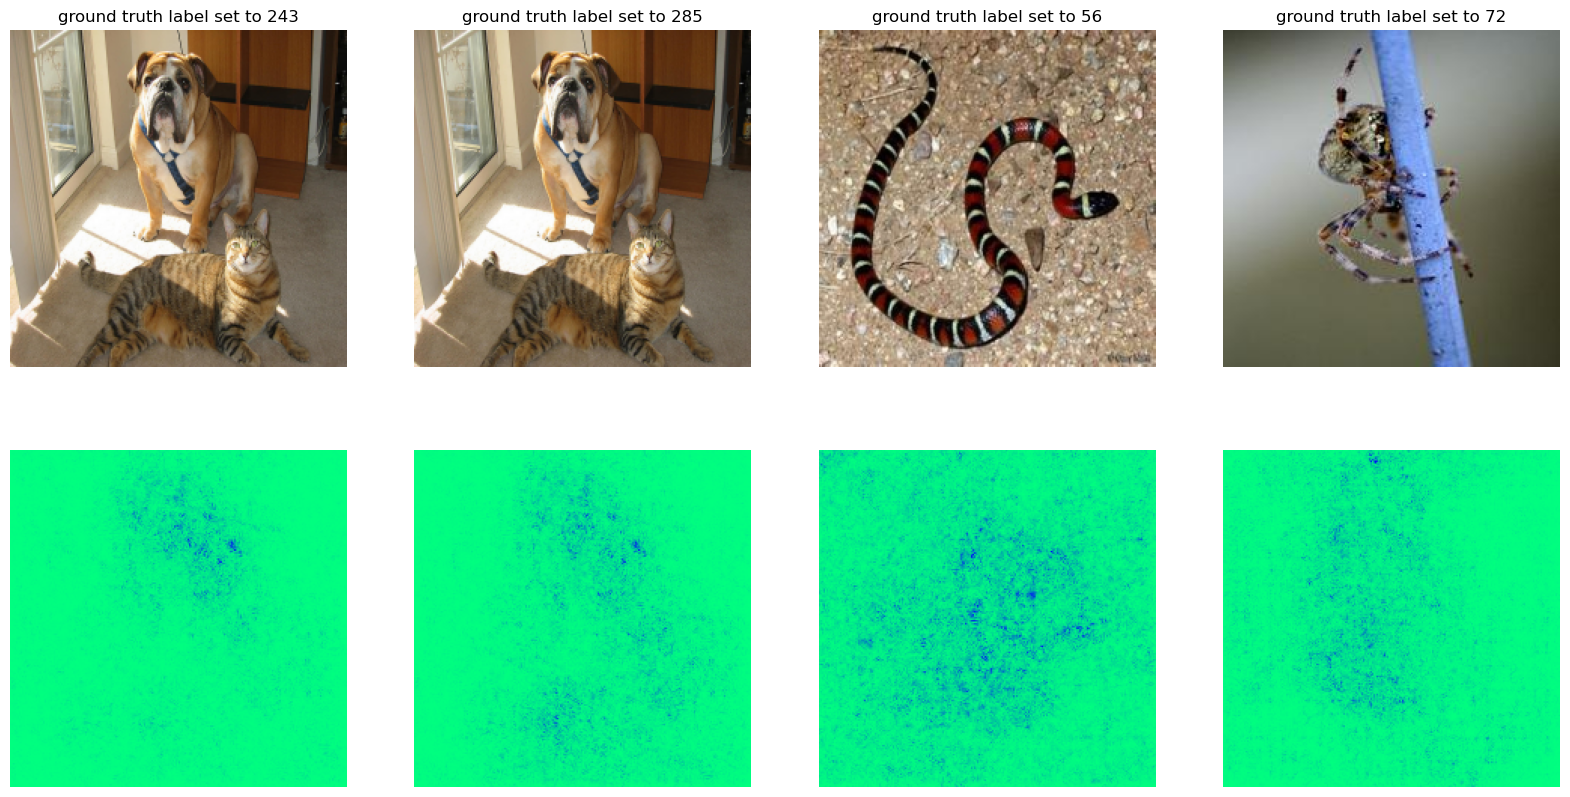

In [34]:
# Please use the same pre-trained network from the previous task for this task
model = torchvision.models.resnet18(weights=True)

# if you finished the task 3.1 and defined your model, then this function should run flawlessly
def show_saliency_maps(X, y):
	# Convert X and y from numpy arrays to Torch Tensors
	X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0)
	y_tensor = torch.LongTensor(y)
	# Compute saliency maps for images in X
	saliency = saliency_maps(X_tensor, y_tensor, model, device)

	# Convert the saliency map from Torch Tensor to numpy array and show images
	# and saliency maps together.
	saliency = saliency.numpy()
	N = len(X)
	for i in range(N):
		plt.subplot(2, N, i + 1)
		plt.imshow(X[i])
		plt.axis('off')
		plt.title('ground truth label set to {}'.format(y[i]))
		plt.subplot(2, N, N + i + 1)
		plt.imshow(saliency[i], cmap=plt.cm.winter_r)
		plt.axis('off')
		plt.gcf().set_size_inches(20, 10)
	plt.show()

show_saliency_maps(X, y)

For the saliency map the gradient is computed from the loss to the input image. The loss is calculated by comparing the predicted label with the true label. Because of that, the label has an impact on how the saliency map looks like. That is why the same image with a different label will have a different saliency map.

---